In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

In [35]:
DQN_EVENT_PATH  = "logs/breakoutdqn/events.out.tfevents.1765134558.mvasandani-1939501.413.0"
DDQN_EVENT_PATH = "/Users/michaelvasandani/Documents/dqn-atari/logs/breakoutdouble/events.out.tfevents.1765125870.mvasandani-1907795.491.0"


In [36]:
def load_scalars(event_path):
    """
    Load scalar data from a TensorBoard event file.
    Returns a dict: tag -> (steps, values)
    """
    ea = event_accumulator.EventAccumulator(
        event_path,
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()

    data = {}
    for tag in ea.Tags()["scalars"]:
        events = ea.Scalars(tag)
        steps = np.array([e.step for e in events], dtype=np.int64)
        vals  = np.array([e.value for e in events], dtype=np.float32)
        data[tag] = (steps, vals)
    return data

In [37]:
def plot_tag(tag, dqn_data, ddqn_data, title, ylabel):
    """
    Plot a scalar tag for DQN vs DDQN.
    """
    if tag not in dqn_data or tag not in ddqn_data:
        print(f"[WARN] Tag '{tag}' not found in both logs.")
        return

    dqn_steps, dqn_vals = dqn_data[tag]
    ddqn_steps, ddqn_vals = ddqn_data[tag]

    plt.figure(figsize=(8, 5))
    plt.plot(dqn_steps, dqn_vals, label="DQN", alpha=0.7)
    plt.plot(ddqn_steps, ddqn_vals, label="Double DQN", alpha=0.7)
    plt.xlabel("Training step")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [38]:
def first_threshold_hit(steps, vals, threshold):
    """
    Return index of first time vals >= threshold.
    If never reached, return None.
    """
    idx = np.where(vals >= threshold)[0]
    if len(idx) == 0:
        return None
    return int(idx[0])

In [39]:
def last_n_stats(vals, n=100):
    """
    Return mean, std, actual_n for last n values.
    """
    if len(vals) == 0:
        return np.nan, np.nan, 0
    n = min(n, len(vals))
    last = vals[-n:]
    return float(last.mean()), float(last.std()), n

In [40]:
dqn_data  = load_scalars(DQN_EVENT_PATH)
ddqn_data = load_scalars(DDQN_EVENT_PATH)

print("DQN tags:",  list(dqn_data.keys()))
print("DDQN tags:", list(ddqn_data.keys()))


DQN tags: ['AvgRew', 'AvgEpLen', 'Episodes']
DDQN tags: ['AvgRew', 'AvgEpLen', 'Episodes']


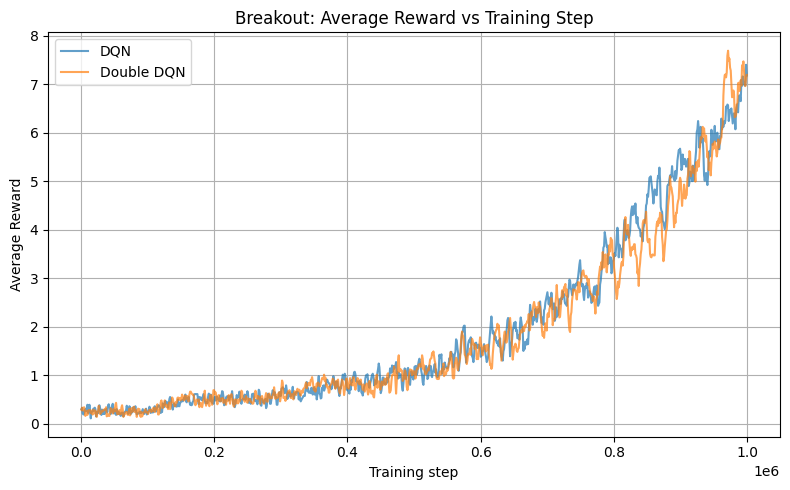

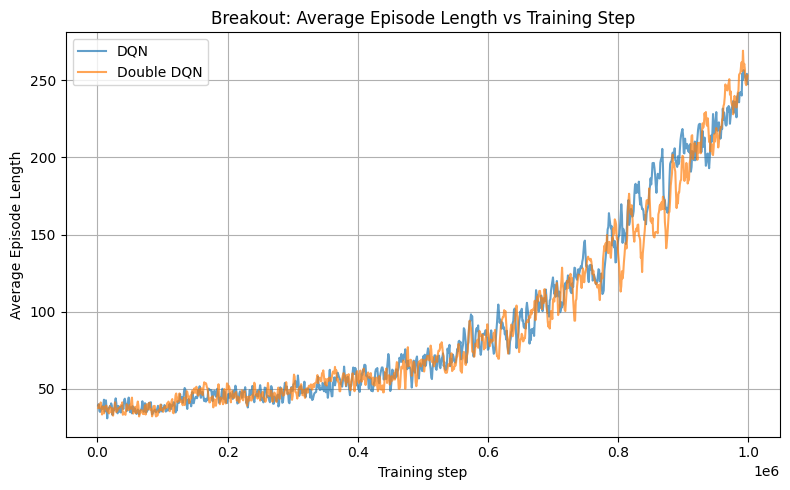

In [41]:
# Avg reward vs training step
plot_tag(
    tag="AvgRew",
    dqn_data=dqn_data,
    ddqn_data=ddqn_data,
    title="Breakout: Average Reward vs Training Step",
    ylabel="Average Reward"
)

# Avg episode length vs training step
plot_tag(
    tag="AvgEpLen",
    dqn_data=dqn_data,
    ddqn_data=ddqn_data,
    title="Breakout: Average Episode Length vs Training Step",
    ylabel="Average Episode Length"
)


In [42]:
# Unpack useful series
(dqn_steps,  dqn_rew)      = dqn_data["AvgRew"]
(ddqn_steps, ddqn_rew)     = ddqn_data["AvgRew"]
(_,          dqn_eplen)    = dqn_data["AvgEpLen"]
(_,          ddqn_eplen)   = ddqn_data["AvgEpLen"]
(_,          dqn_episodes) = dqn_data["Episodes"]
(_,          ddqn_episodes)= ddqn_data["Episodes"]

print("=== Overall mean AvgRew over all logged points ===")
print(f"DQN  mean AvgRew:  {dqn_rew.mean():.2f}")
print(f"DDQN mean AvgRew:  {ddqn_rew.mean():.2f}")


=== Overall mean AvgRew over all logged points ===
DQN  mean AvgRew:  1.92
DDQN mean AvgRew:  1.86


In [43]:
# Sample efficiency: when do they hit certain reward thresholds?
thresholds = [-85.0, -80.0]   # tweak as you like

print("\n=== Steps / episodes to hit AvgRew thresholds ===")
for thr in thresholds:
    dqn_idx  = first_threshold_hit(dqn_steps,  dqn_rew,  thr)
    ddqn_idx = first_threshold_hit(ddqn_steps, ddqn_rew, thr)

    print(f"\nThreshold AvgRew ≥ {thr:.1f}")
    if dqn_idx is not None:
        print(f"  DQN : step {dqn_steps[dqn_idx]:7d}, "
              f"episode {int(dqn_episodes[dqn_idx])}, "
              f"value {dqn_rew[dqn_idx]:.2f}")
    else:
        print("  DQN : never reached")

    if ddqn_idx is not None:
        print(f"  DDQN: step {ddqn_steps[ddqn_idx]:7d}, "
              f"episode {int(ddqn_episodes[ddqn_idx])}, "
              f"value {ddqn_rew[ddqn_idx]:.2f}")
    else:
        print("  DDQN: never reached")



=== Steps / episodes to hit AvgRew thresholds ===

Threshold AvgRew ≥ -85.0
  DQN : step    1000, episode 50, value 0.30
  DDQN: step    1000, episode 52, value 0.29

Threshold AvgRew ≥ -80.0
  DQN : step    1000, episode 50, value 0.30
  DDQN: step    1000, episode 52, value 0.29


In [44]:
# Final segment stats: last N logged points
N = 100

dqn_r_mean,  dqn_r_std,  dqn_r_n  = last_n_stats(dqn_rew,  N)
ddqn_r_mean, ddqn_r_std, ddqn_r_n = last_n_stats(ddqn_rew, N)
dqn_l_mean,  dqn_l_std,  _        = last_n_stats(dqn_eplen,  N)
ddqn_l_mean, ddqn_l_std, _        = last_n_stats(ddqn_eplen, N)

print(f"\n=== Last {N} points (approx final 100 evals) ===")
print(f"DQN  reward: mean={dqn_r_mean:.2f}, std={dqn_r_std:.2f}, n={dqn_r_n}")
print(f"DDQN reward: mean={ddqn_r_mean:.2f}, std={ddqn_r_std:.2f}, n={ddqn_r_n}")
print(f"DQN  ep len: mean={dqn_l_mean:.2f}, std={dqn_l_std:.2f}")
print(f"DDQN ep len: mean={ddqn_l_mean:.2f}, std={ddqn_l_std:.2f}")



=== Last 100 points (approx final 100 evals) ===
DQN  reward: mean=5.94, std=0.61, n=100
DDQN reward: mean=6.02, std=0.86, n=100
DQN  ep len: mean=220.46, std=16.25
DDQN ep len: mean=222.66, std=21.02
